#**Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
import math
from pmdarima.arima import auto_arima
from prettytable import PrettyTable
import xgboost as xgb
import pickle
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

#**Data Collection**

In [2]:
train = pd.read_csv(r'/content/train.csv')
features = pd.read_csv(r'/content/features.csv')
stores = pd.read_csv(r'/content/stores.csv')

#**Data Preprocessing**

In [3]:
train.head()

Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

In [4]:
features.head()

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False

In [5]:
stores.head()

Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

In [6]:
print("train shape:",train.shape)
print("features shape:",features.shape)
print("stores shape:",stores.shape)

train shape: (421570, 5)
features shape: (8190, 12)
stores shape: (45, 3)


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [8]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [9]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [10]:
train.describe()

Store           Dept   Weekly_Sales
count  421570.000000  421570.000000  421570.000000
mean       22.200546      44.260317   15981.258123
std        12.785297      30.492054   22711.183519
min         1.000000       1.000000   -4988.940000
25%        11.000000      18.000000    2079.650000
50%        22.000000      37.000000    7612.030000
75%        33.000000      74.000000   20205.852500
max        45.000000      99.000000  693099.360000

In [11]:
features.describe()

Store  Temperature   Fuel_Price      MarkDown1      MarkDown2  \
count  8190.000000  8190.000000  8190.000000    4032.000000    2921.000000   
mean     23.000000    59.356198     3.405992    7032.371786    3384.176594   
std      12.987966    18.678607     0.431337    9262.747448    8793.583016   
min       1.000000    -7.290000     2.472000   -2781.450000    -265.760000   
25%      12.000000    45.902500     3.041000    1577.532500      68.880000   
50%      23.000000    60.710000     3.513000    4743.580000     364.570000   
75%      34.000000    73.880000     3.743000    8923.310000    2153.350000   
max      45.000000   101.950000     4.468000  103184.980000  104519.540000   

           MarkDown3     MarkDown4      MarkDown5          CPI  Unemployment  
count    3613.000000   3464.000000    4050.000000  7605.000000   7605.000000  
mean     1760.100180   3292.935886    4132.216422   172.460809      7.826821  
std     11276.462208   6792.329861   13086.690278    39.738346      1.877259  
min      -179.260000      0.220000    -185.170000   126.064000      3.684000  
25%         6.600000    304.687500    1440.827500   132.364839      6.634000  
50%        36.260000   1176.425000    2727.135000   182.764003      7.806000  
75%       163.150000   3310.007500    4832.555000   213.932412      8.567000  
max    149483.310000  67474.850000  771448.100000   228.976456     14.313000

In [12]:
stores.describe()

Store           Size
count  45.000000      45.000000
mean   23.000000  130287.600000
std    13.133926   63825.271991
min     1.000000   34875.000000
25%    12.000000   70713.000000
50%    23.000000  126512.000000
75%    34.000000  202307.000000
max    45.000000  219622.000000

In [13]:
print(train.isnull().sum())
print(features.isnull().sum())
print(stores.isnull().sum())

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64
Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64
Store    0
Type     0
Size     0
dtype: int64


In [14]:
data = train.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')
data.head()

Store  Dept        Date  Weekly_Sales  IsHoliday_x  Temperature  \
0      1     1  2010-02-05      24924.50        False        42.31   
1      1     2  2010-02-05      50605.27        False        42.31   
2      1     3  2010-02-05      13740.12        False        42.31   
3      1     4  2010-02-05      39954.04        False        42.31   
4      1     5  2010-02-05      32229.38        False        42.31   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        NaN        NaN        NaN        NaN        NaN   
1       2.572        NaN        NaN        NaN        NaN        NaN   
2       2.572        NaN        NaN        NaN        NaN        NaN   
3       2.572        NaN        NaN        NaN        NaN        NaN   
4       2.572        NaN        NaN        NaN        NaN        NaN   

          CPI  Unemployment  IsHoliday_y Type    Size  
0  211.096358         8.106        False    A  151315  
1  211.096358         8.106        False    A  151315  
2  211.096358         8.106        False    A  151315  
3  211.096358         8.106        False    A  151315  
4  211.096358         8.106        False    A  151315

In [15]:
data.shape

(421570, 17)

##**Handling null Values**

In [16]:
data['MarkDown1'] = data['MarkDown1'].replace(np.nan, 0)
data['MarkDown2'] = data['MarkDown2'].replace(np.nan, 0)
data['MarkDown3'] = data['MarkDown3'].replace(np.nan, 0)
data['MarkDown4'] = data['MarkDown4'].replace(np.nan, 0)
data['MarkDown5'] = data['MarkDown5'].replace(np.nan, 0)

In [17]:
data = data[data['Weekly_Sales'] >= 0]

##**Feature Transformation**

In [18]:

data['Date'] = pd.to_datetime(data['Date'])
data['month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['dayofweek_name'] = data['Date'].dt.day_name()
data['is_weekend'] = np.where(data['dayofweek_name'].isin(['Sunday', 'Saturday']), 1, 0)
data["IsHoliday_x"] = data["IsHoliday_x"].astype(int)

del data['dayofweek_name']

In [19]:
data.to_csv(r'merged_data.csv', index=False)

In [20]:
df1=pd.read_csv(r"merged_data.csv")
df2=df1.copy()
df1.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size',
       'month', 'Year', 'is_weekend'],
      dtype='object')

##**Data Visualisation**


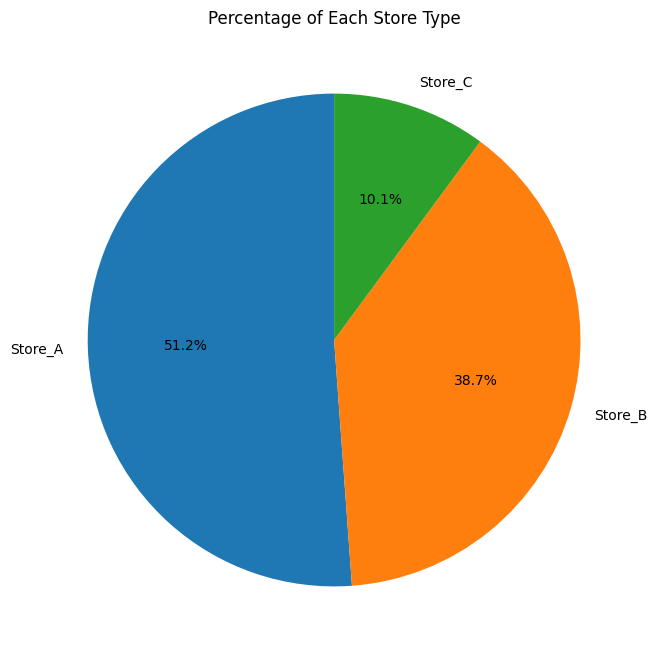

In [21]:
store_type_counts = df1['Type'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(store_type_counts.values, labels=["Store_A","Store_B","Store_C"], autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Each Store Type')
plt.show()

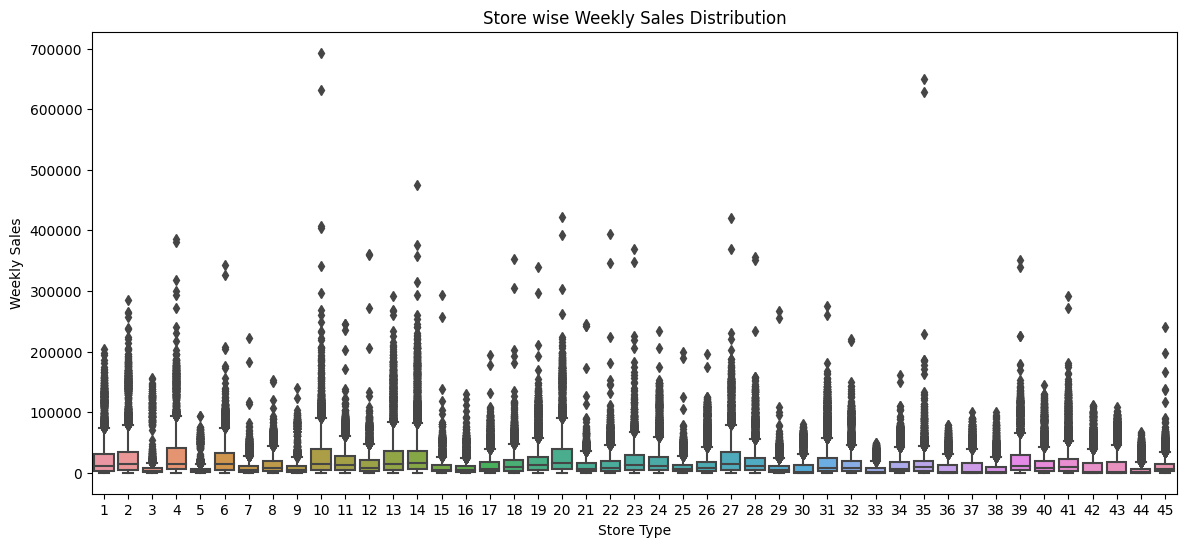

In [23]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Store', y='Weekly_Sales', data=df1)
plt.title('Store wise Weekly Sales Distribution')
plt.xlabel('Store Type')
plt.ylabel('Weekly Sales')
plt.show()

In [24]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Type', y='Weekly_Sales', data=df1)
plt.title('Store Type-wise Weekly Sales Distribution')
plt.xlabel('Store Type')
plt.ylabel('Weekly Sales')
plt.show()


In [25]:
plt.figure(figsize=(8, 6))
sns.barplot(x='IsHoliday_x', y='Weekly_Sales', data=df1)
plt.title('Weekly Sales on Holidays vs. Non-Holidays')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.show()

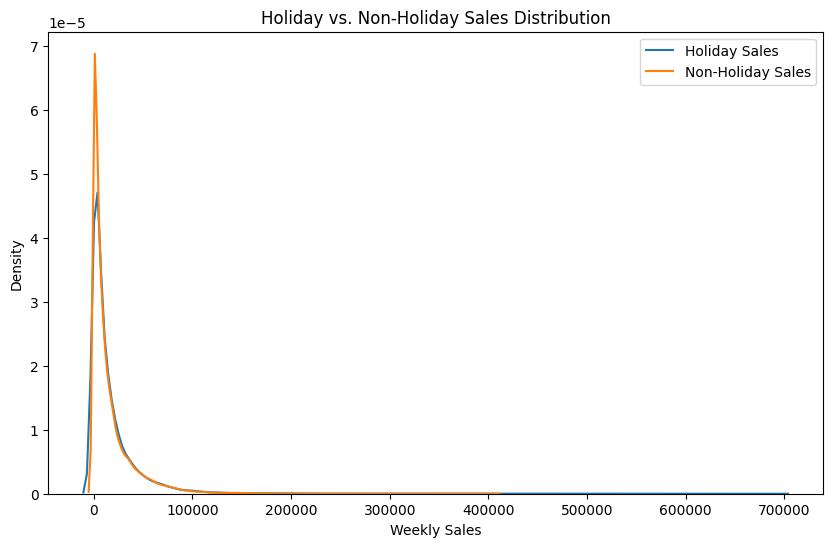

In [26]:
holiday_sales = df1[df1['IsHoliday_x'] == 1]['Weekly_Sales']
non_holiday_sales = df1[df1['IsHoliday_x'] == 0]['Weekly_Sales']
plt.figure(figsize=(10, 6))
sns.kdeplot(holiday_sales, label='Holiday Sales')
sns.kdeplot(non_holiday_sales, label='Non-Holiday Sales')
plt.title('Holiday vs. Non-Holiday Sales Distribution')
plt.xlabel('Weekly Sales')
plt.ylabel('Density')
plt.legend()
plt.show()

In [27]:
df2['Date'] = pd.to_datetime(df2['Date'], format='%Y-%m-%d')
df2.set_index("Date", inplace = True)
df2=df2.drop("Type",axis=1)
df2 = df2.resample('MS').mean()

In [28]:
plt.figure(figsize=(14, 6))
sns.lineplot(x='month', y='Weekly_Sales', data=df2, errorbar=None)
plt.title('Seasonal Sales Trends')
plt.xlabel('Month')
plt.ylabel('Weekly Sales')
plt.show()

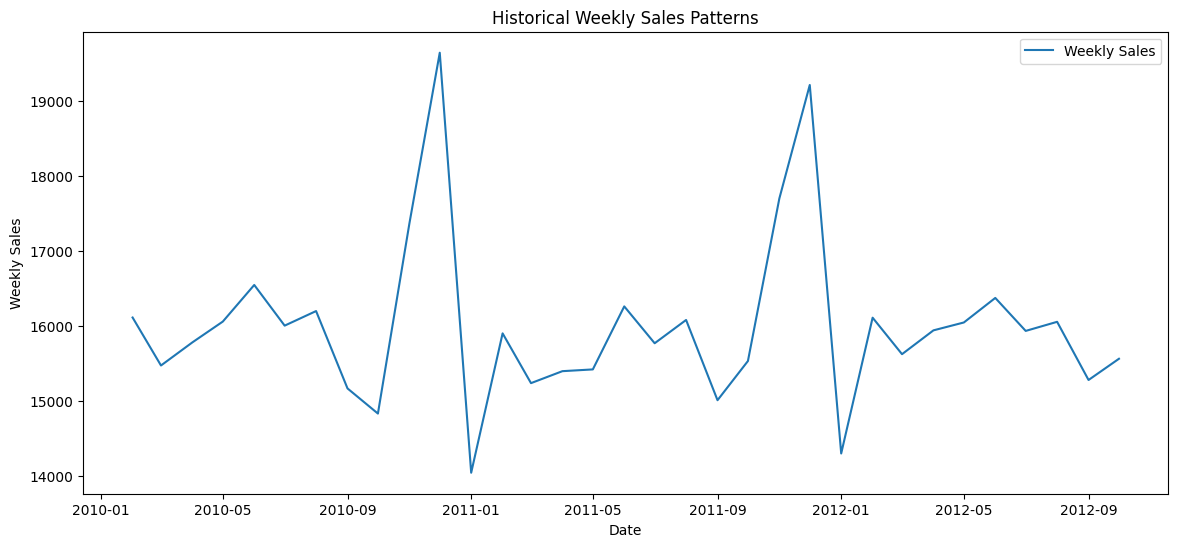

In [29]:
plt.figure(figsize=(14, 6))
plt.plot(df2['Weekly_Sales'], label='Weekly Sales')
plt.title('Historical Weekly Sales Patterns')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

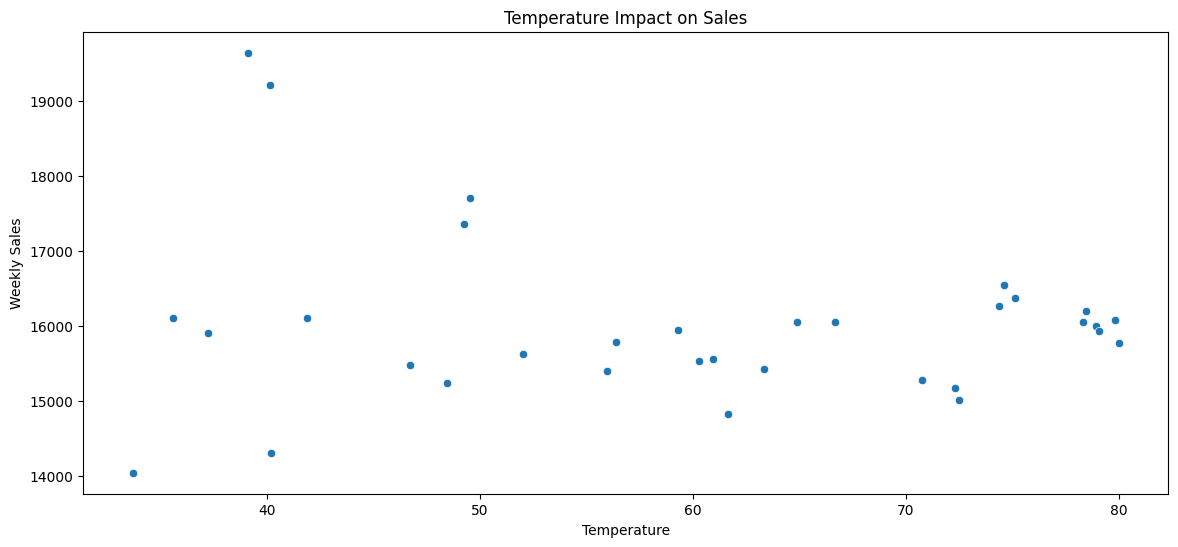

In [30]:
plt.figure(figsize=(14, 6))
sns.scatterplot(x='Temperature', y='Weekly_Sales', data=df2)
plt.title('Temperature Impact on Sales')
plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')
plt.show()

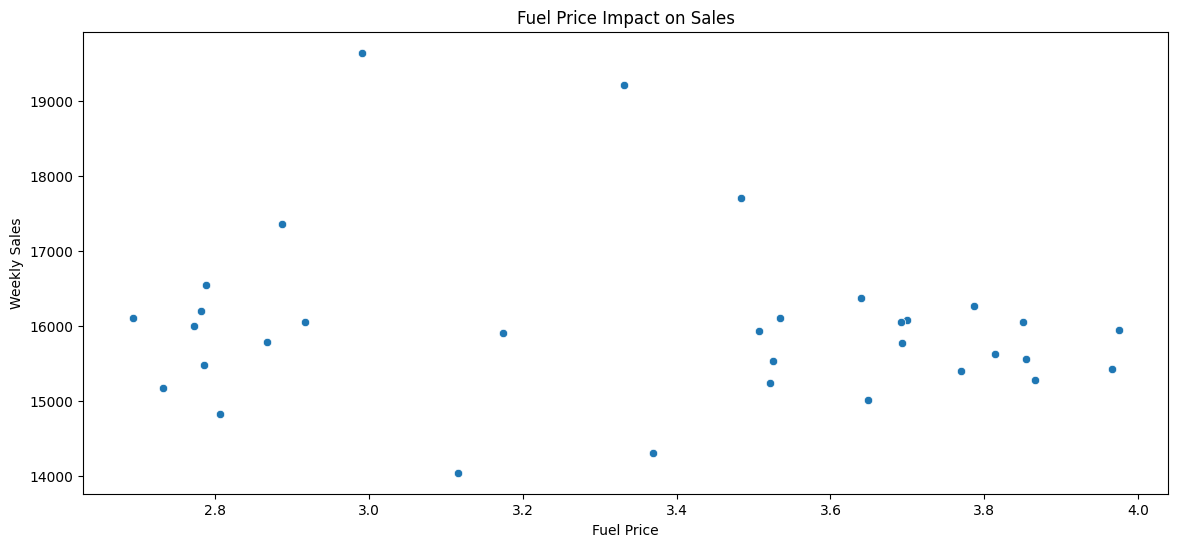

In [31]:
plt.figure(figsize=(14, 6))
sns.scatterplot(x='Fuel_Price', y='Weekly_Sales', data=df2)
plt.title('Fuel Price Impact on Sales')
plt.xlabel('Fuel Price')
plt.ylabel('Weekly Sales')
plt.show()

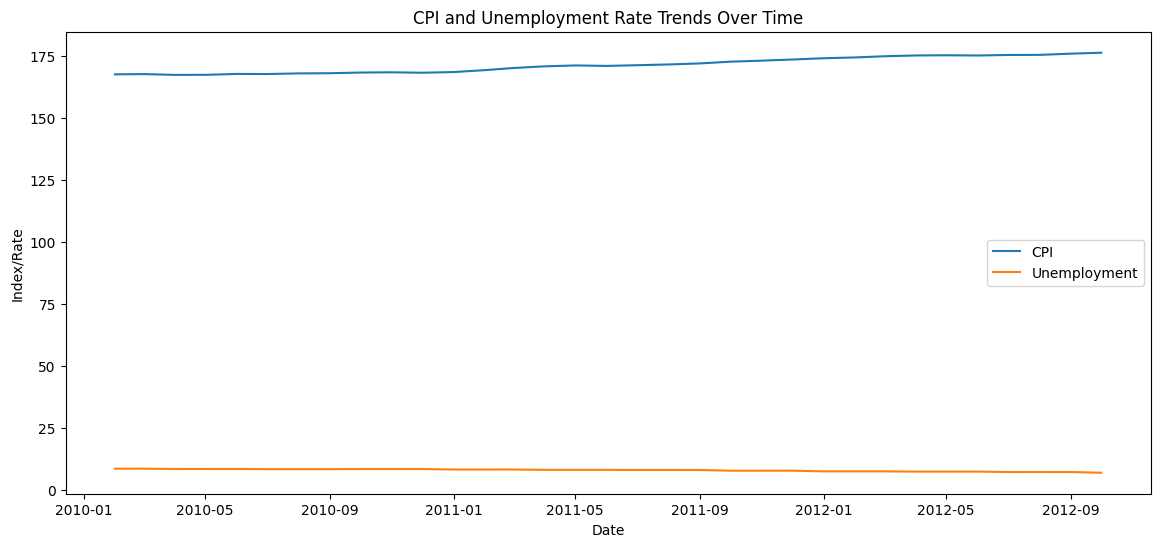

In [32]:
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date', y='CPI', data=df2, label='CPI')
sns.lineplot(x='Date', y='Unemployment', data=df2, label='Unemployment')
plt.title('CPI and Unemployment Rate Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Index/Rate')
plt.legend()
plt.show()

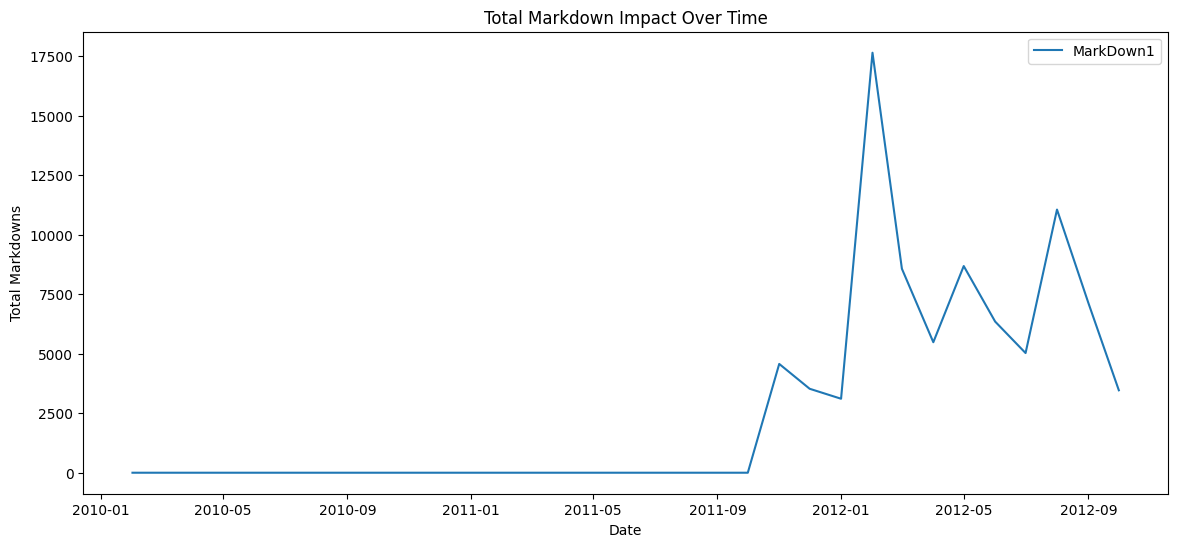

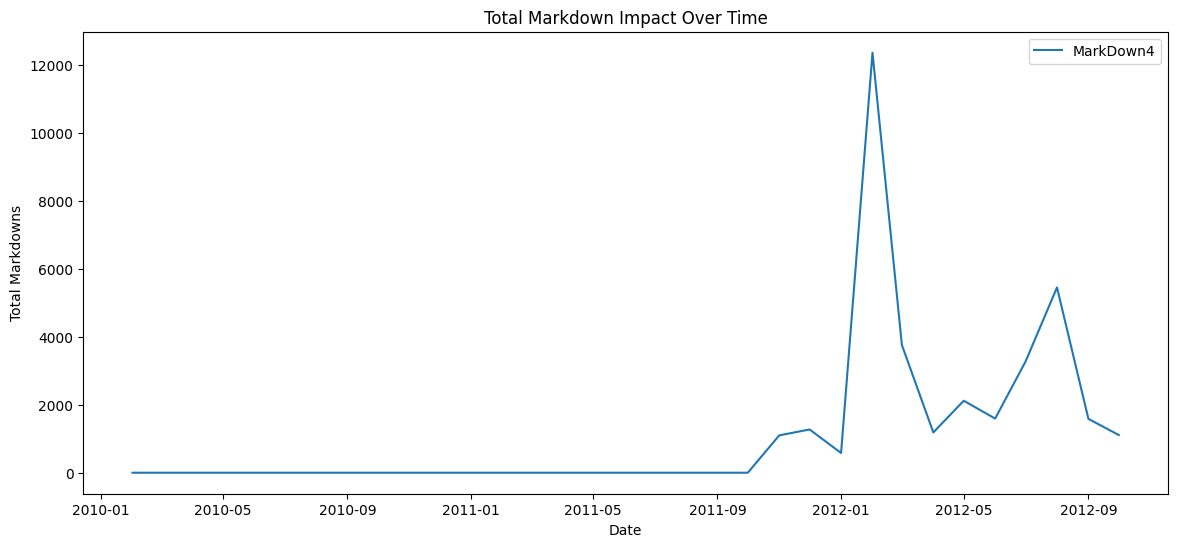

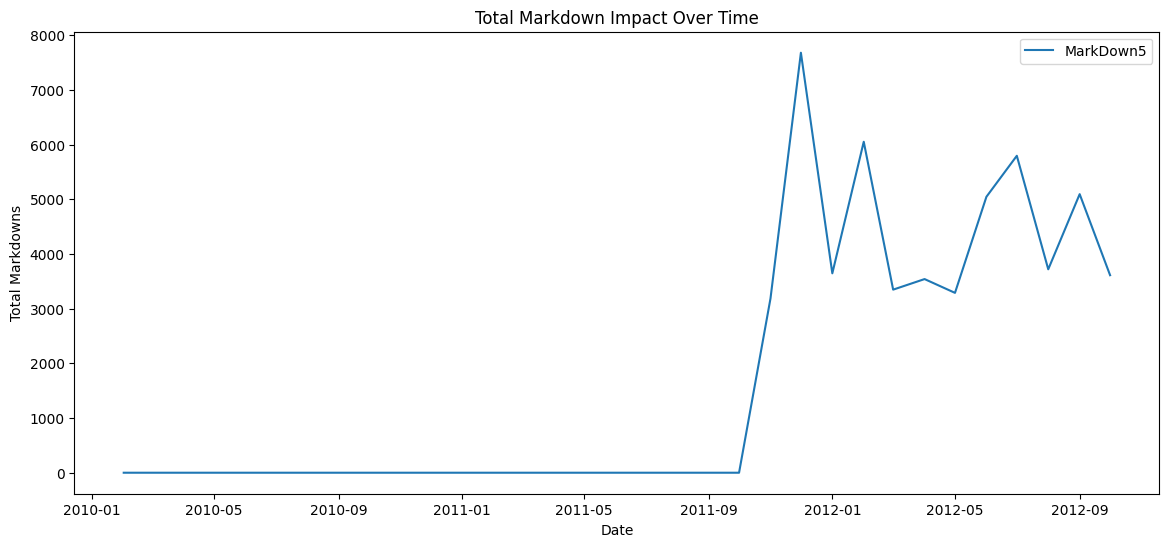

In [33]:
markdown_impact = df2.reset_index().groupby('Date')[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].sum()
for column in markdown_impact.columns:
    plt.figure(figsize=(14, 6))
    plt.plot(markdown_impact.index, markdown_impact[column], label=column)
    plt.title('Total Markdown Impact Over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Markdowns')
    plt.legend()
    plt.show()

In [34]:
numeric_columns = df1.select_dtypes(include=[np.number]).columns
correlation_matrix = df1[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Matrix Heatmap for Features')
plt.show()

In [35]:
from prettytable import PrettyTable
insights_table = PrettyTable()
insights_table.field_names = ["Insight Number", "Insight Description"]
insights_table.add_row(["1", "Percentage of Each Store Type - Visualized the distribution of stores across different types"])
insights_table.add_row(["2-1", "Store wise Weekly Sales Distribution - Analyzed the distribution of weekly sales across 45 stores"])
insights_table.add_row(["2-2", "Store Type-wise Weekly Sales Distribution - Analyzed the distribution of weekly sales across store types"])
insights_table.add_row(["3", "Weekly Sales on Holidays vs. Non-Holidays - Analyzed the impact of holidays on weekly sales"])
insights_table.add_row(["4", "Holiday vs. Non-Holiday Sales Distribution - Compared the distribution of sales during holidays and non-Holidays"])
insights_table.add_row(["5", "Seasonal Sales Trends - Investigated seasonal Sales Trends"])
insights_table.add_row(["6", "Historical Weekly Sales Patterns - Visualized historical patterns in weekly sales"])
insights_table.add_row(["7", "Temperature vs. Weekly Sales - Investigated the relationship between temperature and weekly sales"])
insights_table.add_row(["8", "FuelPrice vs. Weekly Sales - Investigated the relationship between Fuel price and weekly sales"])
insights_table.add_row(["9", "CPI AND UneEmployment Trends - Investigated the CPI and Unemployment Rate Trends Over Time"])
insights_table.add_row(["10", "Total Markdown Impact Over Time - Visualized the cumulative impact of markdowns over time"])
insights_table.add_row(["11", "Correlation Matrix Heatmap - Explored the correlation between numerical features"])
print(insights_table)

+----------------+------------------------------------------------------------------------------------------------------------------+
| Insight Number |                                               Insight Description                                                |
+----------------+------------------------------------------------------------------------------------------------------------------+
|       1        |           Percentage of Each Store Type - Visualized the distribution of stores across different types           |
|      2-1       |        Store wise Weekly Sales Distribution - Analyzed the distribution of weekly sales across 45 stores         |
|      2-2       |     Store Type-wise Weekly Sales Distribution - Analyzed the distribution of weekly sales across store types     |
|       3        |           Weekly Sales on Holidays vs. Non-Holidays - Analyzed the impact of holidays on weekly sales            |
|       4        | Holiday vs. Non-Holiday Sales Distribution 

In [36]:
df1=pd.get_dummies(df1, columns=['Type'])
df1["Type_A"]=df1["Type_A"].apply(lambda x: 1 if x==True else 0)
df1["Type_B"]=df1["Type_B"].apply(lambda x: 1 if x==True else 0)
df1["Type_C"]=df1["Type_C"].apply(lambda x: 1 if x==True else 0)

##**Splitting into Independent and Dependent**

In [37]:
X = df1.drop(columns=['Weekly_Sales'])
X=X[['Store', 'Dept','Size','IsHoliday_x','CPI', 'Temperature','Type_B', 'Type_C',
      'MarkDown4','month', 'Year']]
y = df1['Weekly_Sales']

##**Train and Test**

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
train_data = df2[:int(0.7 * len(df2))]['Weekly_Sales']
test_data = df2[int(0.7 * len(df2)):]['Weekly_Sales']

#**Model Building And Prediction**




##**Linear Regression**

In [39]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [40]:
accuracy_lr = round(lr.score(X_test, y_test) * 100, 7)
mse_lr = round(mean_squared_error(y_test, y_pred_lr), 7)
rmse_lr = round(math.sqrt(mean_squared_error(y_test, y_pred_lr)),7)
mae_lr= round(mean_absolute_error(y_test, y_pred_lr), 10)
training_accuracy_lr = round(lr.score(X_train, y_train) * 100, 7)

print('Accuracy of Linear Regression:', accuracy_lr, '%')
print('Mean Squared Error (MSE) of Linear Regression:', mse_lr)
print('RMSE of Linear Regression:', rmse_lr)
print('MAE of Linear Regression:', mae_lr)
print('Training Accuracy of Linear Regression:', training_accuracy_lr, '%')

Accuracy of Linear Regression: 9.0838447 %
Mean Squared Error (MSE) of Linear Regression: 456450655.8156378
RMSE of Linear Regression: 21364.7058444
MAE of Linear Regression: 14519.1490841106
Training Accuracy of Linear Regression: 8.9196541 %


##**Arima**

In [41]:
model_auto_arima = auto_arima(train_data, trace=True, error_action='ignore', suppress_warnings=True)
model_auto_arima.fit(train_data)
forecast = model_auto_arima.predict(n_periods=len(test_data))

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=405.580, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=398.029, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=399.847, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=399.604, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=513.059, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=401.739, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.313 seconds


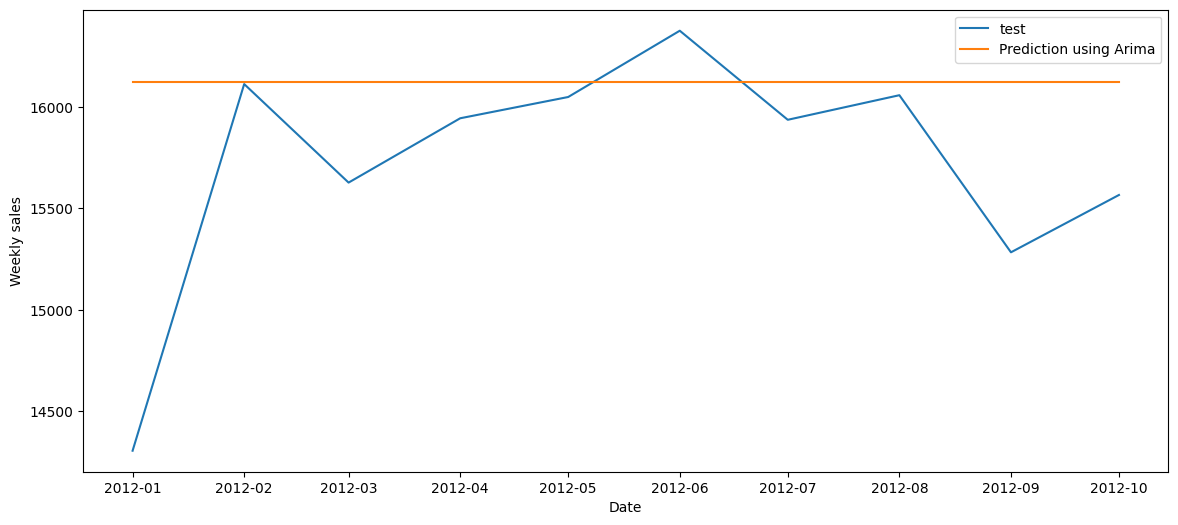

In [42]:
plt.figure(figsize=(14, 6))
pred=pd.DataFrame(forecast,index=test_data.index,columns=["Prediction"])
plt.plot(test_data,label="test")
plt.plot(pred,label="Prediction using Arima")
plt.xlabel("Date")
plt.ylabel("Weekly sales")
plt.legend()
plt.show()

In [43]:
mse_arima = round(mean_squared_error(test_data, forecast),7)
rmse_arima = round(math.sqrt(mse_arima),7)
mae_arima = round(mean_absolute_error(test_data, forecast),7)
r2_arima = round(r2_score(test_data, forecast),7)

print('Mean Squared Error (MSE) of ARIMA:', mse_arima)
print('Root Mean Squared Error (RMSE) of ARIMA:', rmse_arima)
print('Mean Absolute Deviation (MAD) of ARIMA:', mae_arima)
print('R-squared (R2) Score of ARIMA:', r2_arima)

Mean Squared Error (MSE) of ARIMA: 469971.0831842
Root Mean Squared Error (RMSE) of ARIMA: 685.54437
Mean Absolute Deviation (MAD) of ARIMA: 446.9938501
R-squared (R2) Score of ARIMA: -0.5015188


##**Xgb Regressor**

In [44]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', nthread=4, n_estimators=500, max_depth=4, learning_rate=0.5)
xg_reg.fit(X_train, y_train)
y_pred_xg = xg_reg.predict(X_test)

In [45]:
accuracy_xg = round(xg_reg.score(X_test, y_test) * 100,7)
mse_xg = round(mean_squared_error(y_test, y_pred_xg),7)
rmse_xg = round(math.sqrt(mean_squared_error(y_test, y_pred_xg)),7)
mae_xg = round(mean_absolute_error(y_test, y_pred_xg),7)
training_accuracy_xg = round(xg_reg.score(X_train, y_train) * 100,7)

print('Accuracy of XGBoost:', accuracy_xg, '%')
print('Mean Squared Error (MSE) of XGBoost:', mse_xg)
print('RMSE of XGBoost:', rmse_xg)
print('MAE of XGBoost:', mae_xg)
print('Training Accuracy of XGBoost:', training_accuracy_xg, '%')

Accuracy of XGBoost: 94.2834644 %
Mean Squared Error (MSE) of XGBoost: 28700250.4662951
RMSE of XGBoost: 5357.2614708
MAE of XGBoost: 3006.4570688
Training Accuracy of XGBoost: 94.1514171 %


##**RandomForestRegressor**

In [62]:
rf = RandomForestRegressor(n_estimators=50, max_depth=20, min_samples_split=3, min_samples_leaf=1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [47]:
accuracy_rf = round(rf.score(X_test, y_test) * 100,7)
mse_rf = round(mean_squared_error(y_test, y_pred_rf),7)
rmse_rf = round(math.sqrt(mean_squared_error(y_test, y_pred_rf)),7)
mae_rf = round(mean_absolute_error(y_test, y_pred_rf),7)
training_accuracy_rf = round(rf.score(X_train, y_train) * 100,7)

print('Accuracy of Random Forest:', accuracy_rf, '%')
print('Mean Squared Error (MSE) of Random Forest:', mse_rf)
print('RMSE of Random Forest:', rmse_rf)
print('MAE of Random Forest:', mae_rf)
print('Training Accuracy of Random Forest:', training_accuracy_rf, '%')

Accuracy of Random Forest: 96.8394118 %
Mean Squared Error (MSE) of Random Forest: 15867945.1248428
RMSE of Random Forest: 3983.4589398
MAE of Random Forest: 1618.8938365
Training Accuracy of Random Forest: 99.1134281 %


##**Knn Regressor**

In [48]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

In [49]:
accuracy_knn = round(knn.score(X_test, y_test) * 100, 7)
mse_knn = round(mean_squared_error(y_test, y_pred_knn), 7)
rmse_knn = round(math.sqrt(mean_squared_error(y_test, y_pred_knn)), 7)
mae_knn = round(mean_absolute_error(y_test, y_pred_knn), 7)
training_accuracy_knn = round(knn.score(X_train, y_train) * 100, 7)

print('Accuracy of K-Nearest Neighbors:', accuracy_knn, '%')
print('Mean Squared Error (MSE) of K-Nearest Neighbors:', mse_knn)
print('RMSE of K-Nearest Neighbors:', rmse_knn)
print('MAE of K-Nearest Neighbors:', mae_knn)
print('Training Accuracy of K-Nearest Neighbors:', training_accuracy_knn, '%')

Accuracy of K-Nearest Neighbors: 43.1554294 %
Mean Squared Error (MSE) of K-Nearest Neighbors: 285391979.5574568
RMSE of K-Nearest Neighbors: 16893.5484596
MAE of K-Nearest Neighbors: 10158.6665802
Training Accuracy of K-Nearest Neighbors: 62.9135259 %


##**ExtraTreesRegressor**

In [50]:
extra_trees = ExtraTreesRegressor(n_estimators=50, max_depth=20, min_samples_split=3, min_samples_leaf=1)
extra_trees.fit(X_train, y_train)
y_pred_extra_trees = extra_trees.predict(X_test)

In [51]:
accuracy_extra_trees = round(extra_trees.score(X_test, y_test) * 100, 7)
mse_extra_trees = round(mean_squared_error(y_test, y_pred_extra_trees), 7)
rmse_extra_trees = round(math.sqrt(mean_squared_error(y_test, y_pred_extra_trees)), 7)
mae_extra_trees = round(mean_absolute_error(y_test, y_pred_extra_trees), 7)
training_accuracy_extra_trees = round(extra_trees.score(X_train, y_train) * 100, 7)

print('Accuracy of Extra Trees:', accuracy_extra_trees, '%')
print('Mean Squared Error (MSE) of Extra Trees:', mse_extra_trees)
print('RMSE of Extra Trees:', rmse_extra_trees)
print('MAE of Extra Trees:', mae_extra_trees)
print('Training Accuracy of Extra Trees:', training_accuracy_extra_trees, '%')

Accuracy of Extra Trees: 96.6434853 %
Mean Squared Error (MSE) of Extra Trees: 16851607.0254787
RMSE of Extra Trees: 4105.0708917
MAE of Extra Trees: 1633.4978276
Training Accuracy of Extra Trees: 99.1510108 %


In [52]:
regression_metrics = PrettyTable()
regression_metrics.field_names = ["Model", "Training Accuracy", "Testing Accuracy", "MAE", "MSE", "RMSE", "R2"]
regression_metrics.add_row(["ARIMA", "N/A", "N/A", mae_arima, mse_arima, rmse_arima, r2_arima])
regression_metrics.add_row(["Linear Regression", training_accuracy_lr, round(lr.score(X_test, y_test) * 100, 7), round(mean_absolute_error(y_test, y_pred_lr), 7), round(mean_squared_error(y_test, y_pred_lr), 7), round(math.sqrt(mean_squared_error(y_test, y_pred_lr)), 7), "N/A"])
regression_metrics.add_row(["Random Forest", training_accuracy_rf, accuracy_rf, mae_rf, mse_rf, rmse_rf, "N/A"])
regression_metrics.add_row(["XGBoost", training_accuracy_xg, accuracy_xg, mae_xg, mse_xg, rmse_xg, "N/A"])
regression_metrics.add_row(["K-Nearest Neighbors", training_accuracy_knn, round(knn.score(X_test, y_test) * 100, 7), round(mean_absolute_error(y_test, y_pred_knn), 7), round(mean_squared_error(y_test, y_pred_knn), 7), round(math.sqrt(mean_squared_error(y_test, y_pred_knn)), 7), "N/A"])
regression_metrics.add_row(["Extra Trees", training_accuracy_extra_trees, round(extra_trees.score(X_test, y_test) * 100, 7), round(mean_absolute_error(y_test, y_pred_extra_trees), 7), round(mean_squared_error(y_test, y_pred_extra_trees), 7), round(math.sqrt(mean_squared_error(y_test, y_pred_extra_trees)), 7), "N/A"])
print(regression_metrics)

+---------------------+-------------------+------------------+---------------+-------------------+---------------+------------+
|        Model        | Training Accuracy | Testing Accuracy |      MAE      |        MSE        |      RMSE     |     R2     |
+---------------------+-------------------+------------------+---------------+-------------------+---------------+------------+
|        ARIMA        |        N/A        |       N/A        |  446.9938501  |   469971.0831842  |   685.54437   | -0.5015188 |
|  Linear Regression  |     8.9196541     |    9.0838447     | 14519.1490841 | 456450655.8156378 | 21364.7058444 |    N/A     |
|    Random Forest    |     99.1134281    |    96.8394118    |  1618.8938365 |  15867945.1248428 |  3983.4589398 |    N/A     |
|       XGBoost       |     94.1514171    |    94.2834644    |  3006.4570688 |  28700250.4662951 |  5357.2614708 |    N/A     |
| K-Nearest Neighbors |     62.9135259    |    43.1554294    | 10158.6665802 | 285391979.5574568 | 16893

In [53]:
lr = LinearRegression()
lr_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_lr_cv = round(np.sqrt(-lr_scores.mean()), 10)
mae_lr_cv = round(-cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean(), 10)
r2_lr_cv = round(cross_val_score(lr, X_train, y_train, cv=5, scoring='r2').mean(), 10)

print('Cross-Validation Results for Linear Regression:')
print('RMSE (CV):', rmse_lr_cv)
print('MAE (CV):', mae_lr_cv)
print('R2 (CV):', r2_lr_cv)

Cross-Validation Results for Linear Regression:
RMSE (CV): 21768.182054854
MAE (CV): 14605.342039164
R2 (CV): 0.0891209772


In [54]:
mse_arima_cv = round(mean_squared_error(test_data, forecast), 10)
rmse_arima_cv = round(math.sqrt(mse_arima_cv), 10)
mae_arima_cv = round(mean_absolute_error(test_data, forecast), 10)
r2_arima_cv = round(r2_score(test_data, forecast), 10)

print('Cross-Validation Results for ARIMA:')
print('RMSE (CV):', rmse_arima_cv)
print('MAE (CV):', mae_arima_cv)
print('R2 (CV):', r2_arima_cv)

Cross-Validation Results for ARIMA:
RMSE (CV): 685.5443699603
MAE (CV): 446.9938500521
R2 (CV): -0.5015187938


In [55]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', nthread=4, n_estimators=500, max_depth=4, learning_rate=0.5)
xg_scores = cross_val_score(xg_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_xg_cv = round(np.sqrt(-xg_scores.mean()), 10)
mae_xg_cv = round(-cross_val_score(xg_reg, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean(), 10)
r2_xg_cv = round(cross_val_score(xg_reg, X_train, y_train, cv=5, scoring='r2').mean(), 10)

print('Cross-Validation Results for XGBoost:')
print('RMSE (CV):', rmse_xg_cv)
print('MAE (CV):', mae_xg_cv)
print('R2 (CV):', r2_xg_cv)

Cross-Validation Results for XGBoost:
RMSE (CV): 5797.5089255401
MAE (CV): 3072.3352056378
R2 (CV): 0.9353988228


In [57]:
rf = RandomForestRegressor(n_estimators=50, max_depth=20, min_samples_split=3, min_samples_leaf=1)
rf_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_rf_cv = round(np.sqrt(-rf_scores.mean()), 10)
mae_rf_cv = round(-cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean(), 10)
r2_rf_cv = round(cross_val_score(rf, X_train, y_train, cv=5, scoring='r2').mean(), 10)

print('Cross-Validation Results for Random Forest:')
print('RMSE (CV):', rmse_rf_cv)
print('MAE (CV):', mae_rf_cv)
print('R2 (CV):', r2_rf_cv)

Cross-Validation Results for Random Forest:
RMSE (CV): 4340.723854118
MAE (CV): 1690.465081017
R2 (CV): 0.963844304


In [58]:
knn = KNeighborsRegressor(n_neighbors=7)
knn_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_knn_cv = round(np.sqrt(-knn_scores.mean()), 10)
mae_knn_cv = round(-cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean(), 10)
r2_knn_cv = round(cross_val_score(knn, X_train, y_train, cv=5, scoring='r2').mean(), 10)

print('Cross-Validation Results for K-Nearest Neighbors:')
print('RMSE (CV):', rmse_knn_cv)
print('MAE (CV):', mae_knn_cv)
print('R2 (CV):', r2_knn_cv)

Cross-Validation Results for K-Nearest Neighbors:
RMSE (CV): 17704.4791236545
MAE (CV): 10486.6129228216
R2 (CV): 0.3974888931


In [59]:
extra_trees_scores = cross_val_score(extra_trees, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_et_cv = round(np.sqrt(-extra_trees_scores.mean()), 10)
mae_et_cv = round(-cross_val_score(extra_trees, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean(), 10)
r2_et_cv = round(cross_val_score(extra_trees, X_train, y_train, cv=5, scoring='r2').mean(), 10)
print('Cross-Validation Results for Extra Trees:')
print('RMSE (CV):', rmse_et_cv)
print('MAE (CV):', mae_et_cv)
print('R2 (CV):', r2_et_cv)

Cross-Validation Results for Extra Trees:
RMSE (CV): 4458.5044942407
MAE (CV): 1716.8366832913
R2 (CV): 0.9612957523


In [60]:
cross_val_metrics = PrettyTable()
cross_val_metrics.field_names = ["Model", "RMSE (CV)", "MAE (CV)", "R2 (CV)"]
cross_val_metrics.add_row(["Arima", rmse_arima_cv, mae_arima_cv, r2_arima_cv])
cross_val_metrics.add_row(["Linear Regression", rmse_lr_cv, mae_lr_cv, r2_lr_cv])
cross_val_metrics.add_row(["Random Forest", rmse_rf_cv, mae_rf_cv, r2_rf_cv])
cross_val_metrics.add_row(["XGBoost", rmse_xg_cv, mae_xg_cv, r2_xg_cv])
cross_val_metrics.add_row(["K-Nearest Neighbors", rmse_knn_cv, mae_knn_cv, r2_knn_cv])
cross_val_metrics.add_row(["Extra Trees", rmse_et_cv, mae_et_cv, r2_et_cv])
print(cross_val_metrics)

+---------------------+------------------+------------------+---------------+
|        Model        |    RMSE (CV)     |     MAE (CV)     |    R2 (CV)    |
+---------------------+------------------+------------------+---------------+
|        Arima        |  685.5443699603  |  446.9938500521  | -0.5015187938 |
|  Linear Regression  | 21768.182054854  | 14605.342039164  |  0.0891209772 |
|    Random Forest    |  4340.723854118  |  1690.465081017  |  0.963844304  |
|       XGBoost       | 5797.5089255401  | 3072.3352056378  |  0.9353988228 |
| K-Nearest Neighbors | 17704.4791236545 | 10486.6129228216 |  0.3974888931 |
|     Extra Trees     | 4458.5044942407  | 1716.8366832913  |  0.9612957523 |
+---------------------+------------------+------------------+---------------+


In [63]:
pickle.dump(rf,open('final_model.pkl','wb'))